Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Maciej Wilhelmi"

---

# 1. Wielowarstwowe perceptrony (MLP)
Pierwszą architekturą, którą będziemy chcieli sprawdzić jest autokoder oparty o wielowarstwowe perceptrony (MLP). 

## 1.1. Architektura i szczegóły implementacyjne

Zapoznaj się z poniższymi implementacjami kodera i dekodera.

In [2]:
from IPython.display import Code


Code(filename="src/mlp.py")

from torch import nn

from .ae import Autoencoder


class MLPEncoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, latent_dim),
        )

    def forward(self, img):
        return self._layers(img)


class MLPDecoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1 * 28 * 28),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self._layers(z)


class MLPAutoencoder(Autoencoder):

    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=MLPEncoder(latent_dim=latent_dim),
            decoder=MLPDecoder(latent_dim=latent_dim),
        )

Jak już zostałe wspomniane we wprowadzeniu, do deklaracji właściwego autokodera oraz uczenia tego modelu, został wykorzystany PyTorch-Lightning. Model deklarujemy jako klasę dziedziczącą po `LightningModule`, a następnie deklarujemy metody:
- `forward` - czyli standardowe przejście w przód modelu; w tym wypadku będziemy głównie zainteresowani reprezentacjami, stąd `forward` wywołuje tylko moduł kodera,
- `training_step` - metoda obliczająca funkcję kosztu dla podanej paczki (`batch`) danych; w tym wypadku korzystamy z dodatkowej funkcji `reconstruct`, która wywołuje zarówno `forward`, jak i przekazuje wyniki do dekodera; jako funkcję kosztu wykorzystujemy błąd średniokwadratowy (MSE),
- `configure_optimizers` - w tej metodzie tworzymy obiekt optymalizatora (tutaj: Adam) podając również współczynnik uczenia (*learning rate*).

In [3]:
Code(filename="src/ae.py")

from pytorch_lightning import LightningModule
import torch
from torch import nn
from torch.nn import functional as F


class Autoencoder(LightningModule):

    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__()

        self._encoder = encoder
        self._decoder = decoder

    def forward(self, x):
        return self._encoder(x)

    def reconstruct(self, x):
        return self._decoder(z=self(x))

    def training_step(self, batch, batch_size):
        x, _ = batch
        xr = self.reconstruct(x)

        loss = F.mse_loss(input=xr, target=x)
        self.log("train/mse", loss.detach().item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

## 1.2. Uczenie modelu

Ze względu na czas obliczeń oraz ograniczone zasoby czasowe w trakcie laboratorium, w repozytorium zostały dołączone gotowe przeuczone modele. Dla zainteresowanych podany jest poniżej kod użyty w celu wyuczenia modelu.

**Uwaga:** W celach uproszczenia kodu i toku rozumowania został przyjęty rozmiar wektora reprezentacji równy `latent_dim = 2`. W rzeczywistych zastosowaniach tak niska wymiarowość nie jest pożądana ze względu na silne ograniczenie pojemności / możliwości zakodowania danych.

In [4]:
LOG_PATH = "./data/MLP/logs/"
CHECKPOINT_PATH = "./data/MLP/model.chkpt"

In [5]:
%load_ext tensorboard
%tensorboard --logdir $LOG_PATH --host 0.0.0.0 --port 6006

In [6]:
from src.dataset import SampledMNISTData
from src.mlp import MLPAutoencoder

Zakomentowany kod do uczenia modelu

W przypadku chęci modyfikacji, proszę odkomentować kod, przeuczyć model i zapisać go za pomocą metody `save_checkpoint`.

In [7]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger

# mlp_ae = MLPAutoencoder(latent_dim=2)
# trainer = Trainer(
#     max_epochs=10, 
#     logger=TensorBoardLogger(save_dir=LOG_PATH, name="mlp_ae", default_hp_metric=False),
#     checkpoint_callback=False,
# )
# mnist = SampledMNISTData(num_samples_per_class=-1)

# trainer.fit(
#     model=mlp_ae, 
#     train_dataloaders=mnist,
# )

# trainer.save_checkpoint(filepath=CHECKPOINT_PATH)

Wczytujemy przeuczony model:

In [8]:
mlp_ae = MLPAutoencoder.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    latent_dim=2,
)

## 1.3. Badanie jakości reprezentacji w zadaniu

Wczytujemy losową próbkę zbioru danych MNIST:

In [9]:
mnist = SampledMNISTData(num_samples_per_class=100, seed=42)

Dla każdej próbki wyciągamy jej reprezentację (wektor dwu-wymiarowy) oraz etykietę:

In [10]:
from src.utils import extract_representations


representations = extract_representations(
    model=mlp_ae,
    dataset=mnist,
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
from src.utils import evaluate_linear    


auc_train, auc_test = evaluate_linear(
    z_train=representations["train"]["z"],
    y_train=representations["train"]["y"],
    z_test=representations["test"]["z"],
    y_test=representations["test"]["y"],
)

print(f"AUC => train: {auc_train * 100.0:.2f} [%], test: {auc_test * 100.0:.2f} [%]")

AUC => train: 83.44 [%], test: 84.51 [%]


## 1.4. Wizualizacja przestrzeni reprezentacji

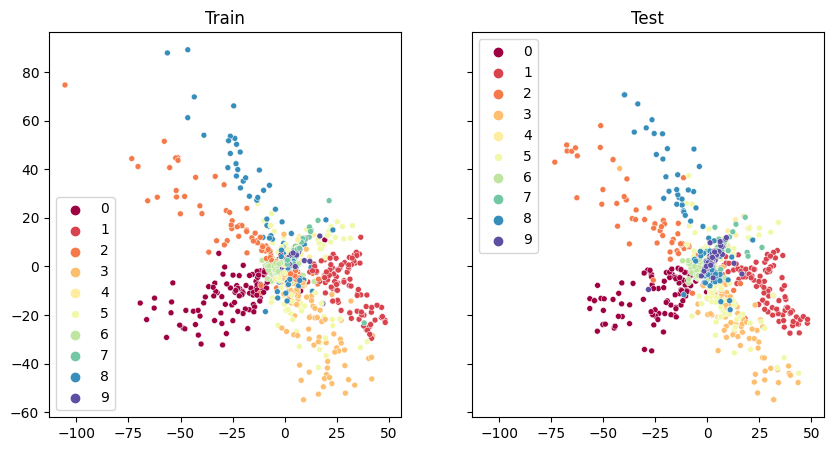

In [13]:
%matplotlib inline

from src.utils import visualize_latent_spaces


visualize_latent_spaces(representations)

## 1.5. Wizualizacja jakości rekonstrukcji

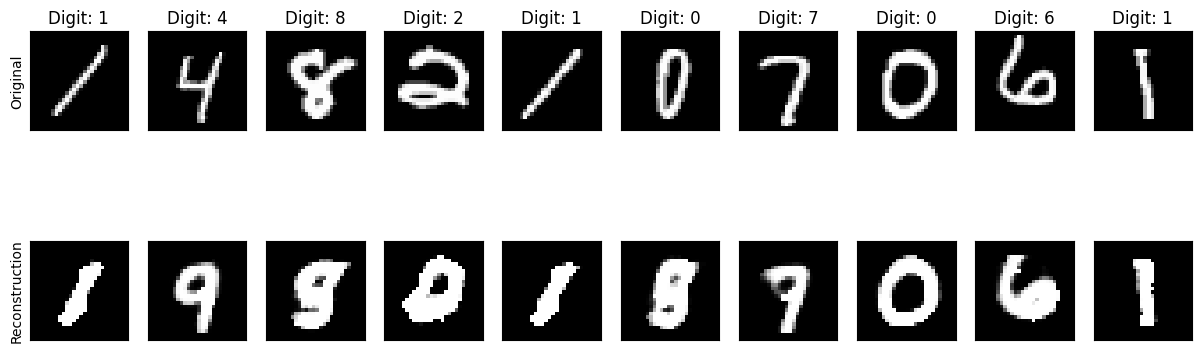

In [12]:
%matplotlib inline

from src.utils import visualize_random_sample

    
visualize_random_sample(model=mlp_ae, dataset=mnist.mnist_train)

## 1.6. Odporność modelu na transformacje (symetrie)

Podczas ostatniego wykładu (`Wykład 2`) omówione zostały dwa podejścia do opisywania struktury danych, mianowicie: symetrie oraz koncepcja separacji skali. Dobry model powinien być odporny na transformacje wynikające z akcji grupy symetrii związanej z konkretnym typem danych.

W przypadku obrazów, które tutaj rozważamy na przykładzie zbioru MNIST, jedną z grup symetrii jest **grupa translacji** (przesunięć). Oznacza to, że niezależnie położenia danego obiektu (tutaj: cyfry) na obrazie, model powinien uzyskiwać taką samą reprezentację (lub bardzo podobną).

Zbadamy teraz jaka jest odporność autokodera MLP na przesunięcia cyfr na obrazie.

## Zadanie 1.1 (2 pkt)
Zaimplementuj funkcję `shift`, która przesunie każdy piksel na obrazie wejściowym `img` (rozmiaru `28 x 28`) o `dx` pikseli w prawo oraz `dy` pikseli w dół. Funkcja powinna obsługiwać:
- ujemne wartości dla tych parametrów przesunięć, tzn. `dx < 0` (w lewo) oraz `dy < 0` (do góry),
- "zawijanie" zawartości, np. jeśli piksel przy przesunięciu w prawo wyszedłby poza widoczny obszar, powinien zostać "zawinięty" i pojawić się z lewej strony obrazu.

In [13]:
import torch


def shift(img: torch.Tensor, dx: int, dy: int) -> torch.Tensor:
    # TU WPISZ KOD
    img_transformed = torch.roll(img, shifts=(dx, dy), dims=(1, 0))
    
    return img_transformed

Wybieramy dowolną instancję ze zbioru danych:

In [14]:
img, _ = mnist.mnist_train[200]

Zbadanie odporności na **przesunięcia poziome**:

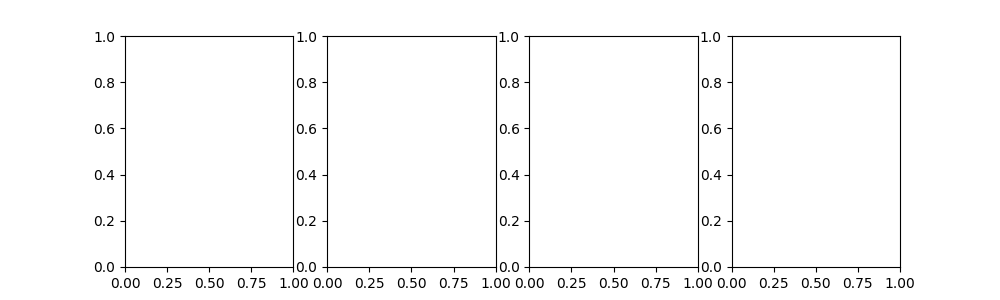

In [15]:
%matplotlib widget

from src.transforms import plot_transformation


def shift_horizontally(image: torch.Tensor, dx: int) -> torch.Tensor:
    return shift(img=image, dx=dx, dy=0)

    
plot_transformation(
    image=img,
    model=mlp_ae,
    transformation_fn=shift_horizontally,
)

Odporność na **przesunięcia pionowe**:

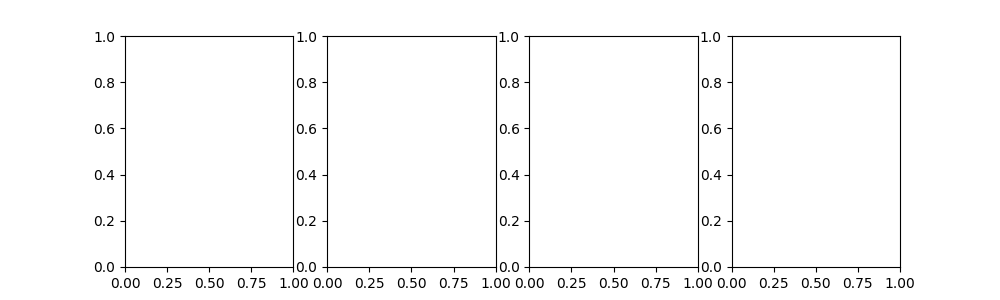

In [16]:
%matplotlib widget


def shift_vertically(image: torch.Tensor, dy: int) -> torch.Tensor:
    return shift(img=image, dx=0, dy=dy)


plot_transformation(
    image=img,
    model=mlp_ae,
    transformation_fn=shift_vertically,
)

## Zadanie 1.2 (0.5 pkt)
Czy autokoder MLP jest odporny na przesunięcia obiektów? Z czego to może wynikać?

Nie jest odporny, może to wynikać z tego, że traktuje on obraz jako zbiór pikseli i dla każdego osobno określa cechy, nie ma zatem informacji odnośnie całej struktury obrazu i zależności pomiędzy pikselami.